# Finite Elements Lab 2 Worksheet

##### Georges Limbert

###### nCATS, Faculty of Engineering and the Environment, University of Southampton

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Aims

The aim of this computer laboratory is to gain a practical insight into the fundamental steps required to program a simple finite element code to solve a problem of elasticity. In doing so, you will learn:

* How to recast the PDE problem into a variational form
* To derive the formulation of a 2D finite element
* To create a simple structured mesh generator to mesh a 2D domain
* To create an assembly procedure for the stiffness matrix of a 2D structure
* How to numerically solve the variational problem for a practical example

The numerical environment chosen for this laboratory is [IPython](http://ipython.org).


## Basic problem: linear elasticity


Let's consider a 2D solid body $\Omega $ at rest, subjected to body forces ${\bf{b}}$, prescribed displacements ${\bf{\bar d}}$ and tractions ${\bf{\bar t}}$. The problem of elasticity is defined as follows:

$$
\begin{align}
{\text{div}}\sigma  + {\bf{b}} & = {\bf{0}} & {\bf x}(x,y) &\text{ in } \Omega \\
{\bf{d}}(u,v) &= {\bf{\bar d}}(u,v) & {\bf x}(x,y) &\text{ on } \partial {\Omega
_u} \\
{\bf{t}}({\bf x}) &= {\bf{\bar t}}({\bf x}) & {\bf x}(x,y) &\text{ on }\partial {\Omega_\sigma}
\end{align}
$$

$\sigma $ is the symmetric Cauchy stress tensor.


### Question 1


Apply integration by parts to the PDE ${\text{div}}\sigma  + {\bf{b}} = {\bf{0}}$
with the divergence theorem (relation between the flow (flux) of a vector field
though a surface and the behavior inside the surface) recast it into its
variational form. You will also take into account the conditions about the
**test function** $\upsilon$ on the boundary where
${\bf{d}}$ is prescribed.

#### Answer

Multiply by the test function $\upsilon$ and integrate by parts over the domain to get

$$
 \int_{\partial \Omega} \upsilon \sigma +\int_{\Omega} -\sigma \cdot \nabla \upsilon + {\bf b} \upsilon = {\bf 0}.
$$

Split the boundary piece into two terms: $\partial \Omega = \partial \Omega_u + \partial \Omega_{\sigma}$, as in the split above. As the test function vanishes on the part of the boundary $\partial \Omega_u$ the first term becomes

$$
  \int_{\partial \Omega_{\sigma}} \upsilon \sigma \cdot \hat{\bf n} =  \int_{\partial \Omega_{\sigma}} \upsilon \bar{\bf t}.
$$

I'm going to switch to using index notation here, together with the summation convention (any repeated index is summed over).

So, the problem to solve is

$$
  \nabla_i \sigma_{ij} + b_j = 0.
$$

Pick the test function $\upsilon$. This will vanish on the part of the boundary where the displacement is given, $\partial \Omega_u$. Multiply the equation by the test function and integrate over the domain.

$$
  \int_{\Omega} \left( \upsilon \nabla_i \sigma_{ij} + \upsilon b_j \right) = 0.
$$

Apply Gauss' theorem to the first term, getting

$$
  \int_{\partial \Omega_{\sigma}} \upsilon \sigma_{ij} \hat{n}_i - \int_{\Omega} \left( \sigma_{ij} \nabla_i \upsilon - \upsilon b_j \right) = 0.
$$

In this step we used that the test function vanishes on $\partial \Omega_u$.

Now use the physical definition ${\bf t}_j = \sigma_{ij} \hat{n}_i$; the traction is the stress in a particular direction. On the boundary $\Omega_{\sigma}$ this traction is prescribed. Therefore, after rearranging, we get

$$
  \int_{\Omega} \sigma_{ij} \nabla_i \upsilon = \int_{\Omega} \upsilon b_j - \int_{\partial \Omega_{\sigma}} \upsilon \bar{t}_j.
$$

We now use the physical relationship that links the stress to the displacements. We have

$$
  \sigma_{ij} = C_{ijkl} \varepsilon_{kl} = C_{ijkl} \nabla_k d_l
$$

where ${\bf d}$ is the displacement, which is the unknown we're trying to solve for. Writing this out in full we have

$$
  \int_{\Omega} C_{ijkl} \nabla_k d_l \nabla_i \upsilon = \int_{\Omega} \upsilon b_j - \int_{\partial \Omega_{\sigma}} \upsilon \bar{t}_j.
$$

Finally we have to make a choice for our representation of the unknowns: the displacement, and the test function.

Restrict to a single element for now. Given the element nodes with physical coordinates ${\bf x}^A$, where $A = 0, \dots, 3$ (or equivalently $1, \dots, 4$ depending on how you count), we can define the shape functions $N^A$ which satisfy

$$
  {\bf x} = N^A {\bf x}^A.
$$

Note that we are using Einstein summation convention over the node labels $A$ here, in the same way as we did over the coordinate indices above.

We also *choose* to write

$$
\begin{align}
  && \upsilon &= N^A \upsilon^A, \\ && {\bf d} & = N^A {\bf d}^A \\ \implies && d_l & = N^A d^A_l.
\end{align}
$$

Note that $\upsilon^A$ and $d^A_l$ are *coefficients*; they depend on the element we're in, but not on the spatial coordinates.

Substituting these choices into the problem above we get

$$
  \int_{\Omega} \upsilon^A d^B_l C_{ijkl} \nabla_k N^B \nabla_i N^A = \int_{\Omega} \upsilon^A N^A b_j - \int_{\partial \Omega_{\sigma}} \upsilon^A N^A \bar{t}_j.
$$

As the test function is arbitrary, and the $\upsilon^A$ are just coefficients, we can eliminate those coefficients everywhere. Defining the shorthand notation $B^A_i = \nabla_i N^A$ we thus have the equation

$$
  \int_{\Omega} d^B_l C_{ijkl} B^B_k B^A_i = \int_{\Omega} N^A b_j - \int_{\partial \Omega_{\sigma}} N^A \bar{t}_j.
$$

Assuming we can calculate the shape functions and their derivatives at any point, this gives us a *linear* equation for the unknown coefficients $d^B_l$.

We can now write this explicitly as a matrix problem, identifying the "physical meaning" of the terms. We first have to reorganize the unknown coefficents $d^B_l$ into a vector. We do that by defining an ordering. Assume that we're working in $N_{\text{dim}}$ dimensions ($2$ in what follows), and there are $N_{\text{nodes}}$ nodes. By numbering the dimensions as $j = 0, \dots, N_{\text{dim}}-1$ and the nodes as $A = 0, \dots, N_{\text{nodes}}-1$, we define

$$
  \alpha = N_{\text{dim}} A + j
$$

as the index into the vector of unknowns $d_{\alpha}$. That is, in 2 dimensions with 4 nodes (one quadrilateral element) we have something like

$$
  d_{\alpha} = \left[ d^0_0, d^0_1, d^1_0, d^1_1, d^2_0, d^2_1, d^3_0, d^3_1 \right].
$$

We can then write the problem as

$$
  K_{\alpha \beta} d_{\beta} =  F^{\text{(body)}}_{\alpha} + F^{\text{(boundary)}}_{\alpha}
$$

where

$$
\begin{align}
  F^{\text{(body)}}_{2 A + j} & = \int_{\Omega} N^A b_j, \\
  F^{\text{(boundary)}}_{2 A + j} & = \int_{\partial \Omega_{\sigma}} N^A \bar{t}_j, \\
  K_{2 A + j, 2 B + l} & = \int_{\Omega} C_{ijkl} B^A_i B^B_k.
\end{align}
$$

We have the three terms giving the element stiffness matrix $K$, the load due to body forces ${\bf F}^{\text{(body)}}$, and the load due to boundary forces ${\bf F}^{\text{(boundary)}}$.

However, we still have that nasty 4-tensor $\mathbb{C}$ for the constituitive relationship. It's stated that this can be rewritten as

$$
  \sigma_{\tilde{a}} = C_{\tilde{a}\tilde{b}} \epsilon_{\tilde{b}}
$$

where $\tilde{a} = (xx), (yy), (xy)$. 

However, I find this a pain to understand. Using the [expression from Wikipedia](http://en.wikiversity.org/wiki/Introduction_to_Elasticity/Constitutive_relations#Isotropic_materials) we get that

$$
  C_{ijkl} = \frac{E \nu}{(1 + \nu) (1 - 2 \nu)} \delta_{ij} \delta_{kl} + \frac{E}{2 ( 1 + \nu )} \left( \delta_{ik} \delta_{jl} + \delta_{il} \delta_{jk} \right)
$$

where $\delta_{ij}$ is the standard Kronecker delta function ($1$ when $i = j$, $0$ otherwise). This form is likely less efficient, but keeps the expression in the form above.

## Constituitive relationship


To relate stress and strain one must define what is called a
**constitutive relationship**. In other branches of physics other types of
relationships would be used (e.g. relation between strain and temperature).

In the case of isotropic linear elasticity (Hooke's elasticity) the Cauchy
stress tensor is related to the strain tensor $\varepsilon $ through the
following relationship:

$$
\begin{equation}
\sigma = \mathbb{C} : {\bf \varepsilon}
\end{equation}
$$

where $\mathbb{C}$ is the elasticity tensor.

Equation (2) is a **tensor equation** (valid in any coordinate system). If
one decides to use a Cartesian coordinate system (2) can be written in index
notation as:

$$
\begin{equation}
{\left( {\bf \sigma}  \right)_{ij}} = {\sigma _{ij}} = \left( \mathbb{C} : {\bf \varepsilon}
\right)_{ij} = \mathbb{C}_{ijkl} \varepsilon_{kl} \quad \left\{
{{\text{2D}}:i,j,k,l:1 \dots 2; \quad {\text{3D}}:i,j,k,l:1 \dots 3} \right\}
\end{equation}
$$

Please note that we use the following convention: bold characters represent
vectors, matrices or tensors.

Because the Cauchy, strain and elasticity tensors are symmetric and the material
isotropic one can simplify the tensorial constitutive equation into a matrix
equation involving vectors and a second-order matrix.

$$
\begin{equation}
\left\{ {\bf \sigma}  \right\} = \left\{ \begin{array}{l}
{\sigma _{xx}}\\
{\sigma _{yy}}\\
{\sigma _{xy}}
\end{array} \right\} = \underbrace {\frac{E}{{1 - {\nu ^2}}}\left[
{\begin{array}{*{20}{c}}
1&\nu &0\\
\nu &1&0\\
0&0&{\frac{{1 - \nu }}{2}}
\end{array}} \right]}_{\left[ \mathbb{C} \right]}\underbrace {\left\{ \begin{array}{l}
{\varepsilon _{xx}}\\
{\varepsilon _{yy}}\\
2{\varepsilon _{xy}}
\end{array} \right\}}_{\left\{ {\bf \varepsilon} \right\}}
\end{equation}
$$

$\left\{ {E,\nu } \right\}$ are material properties, respectively the Young's
modulus and Poisson's ratio which characterise the stiffness and compressibility
of the material.

Let’s consider a 4-noded bi-linear interpolation element (Figure 1).

![Image](./Finite Elements/img-1.svg)


The shape functions chosen here are simple linear Lagrange polynomials but other
forms could be used (quadratic Lagrange, Hermite, NURBS, etc):


\begin{equation}
{N_i} = \frac{1}{4}(1 + {\xi_i} \xi )(1 + {\eta _i}\eta )
\quad {\xi _i},{\eta _i} =  - 1,1 
\end{equation}


There are as many shape functions as nodes in the element, i.e. 4:


\begin{equation}
\left\{
\begin{array}{rl}
N_1 &= \frac{1}{4}\left( {1 - \xi } \right)\left( {1 - \eta } \right)\\
N_2 &= \frac{1}{4}\left( {1 + \xi } \right)\left( {1 - \eta } \right)\\
N_3 &= \frac{1}{4}\left( {1 + \xi } \right)\left( {1 + \eta } \right)\\
N_4 &= \frac{1}{4}\left( {1 - \xi } \right)\left( {1 + \eta } \right)
\end{array}
\right\}
\end{equation}


We are using an **isoparametric formulation** which means that the
**position vector** and **displacement vector** are interpolated using
the same order of shape (or interpolation) functions.


#### Interpolation of the position vector (discretisation)

$$
\begin{equation}
{\bf{x}}\left( {{\xi ^e},t} \right) = {{\bf{x}}_1}(t){N_1}\left( {{\xi ^e}}
\right) + {{\bf{x}}_2}(t){N_2}\left( {{\xi ^e}} \right) +
{{\bf{x}}_3}(t){N_3}\left( {{\xi ^e}} \right) + {{\bf{x}}_4}(t){N_4}\left( {{\xi
^e}} \right)
\end{equation}
$$

where

$$
\begin{equation}
{{\bf{x}}_A}(t) = {\rm{position}}\,(node\,A) = \left\{ \begin{array}{l}
{x_A}\\
{y_A}
\end{array} \right\}
\end{equation}
$$

$$
\begin{equation}
{\bf{x}}\left( {{\xi ^e},t} \right) = {\left\{ {\begin{array}{*{20}{c}}
{x(t)}\\
{y(t)}
\end{array}} \right\}_{node\,1}}{N_1}\left( {{\xi ^e}} \right) + {\left\{
{\begin{array}{*{20}{c}}
{x(t)}\\
{y(t)}
\end{array}} \right\}_{node\,2}}{N_2}\left( {{\xi ^e}} \right) + {\left\{
{\begin{array}{*{20}{c}}
{x(t)}\\
{y(t)}
\end{array}} \right\}_{node\,3}}{N_3}\left( {{\xi ^e}} \right) + {\left\{
{\begin{array}{*{20}{c}}
{x(t)}\\
{y(t)}
\end{array}} \right\}_{node\,4}}{N_4}\left( {{\xi ^e}} \right)
\end{equation}
$$

#### Interpolation of the displacement vector (discretisation)

$$
\begin{equation}
{\bf{d}}\left( {{\xi ^e},t} \right) = {{\bf{d}}_1}(t){N_1}\left( {{\xi ^e}}
\right) + {{\bf{d}}_2}(t){N_2}\left( {{\xi ^e}} \right) +
{{\bf{d}}_3}(t){N_3}\left( {{\xi ^e}} \right) + {{\bf{d}}_4}(t){N_4}\left( {{\xi
^e}} \right)
\end{equation}
$$

where

$$
\begin{equation}
{{\bf{d}}_A}(t) = {\rm{displacement}}\,(node\,A) = \left\{ \begin{array}{l}
{u_A}\\
{v_A}
\end{array} \right\}
\end{equation}
$$

## Degrees of freedom


We can arrange all the degrees of freedom of the element in one vector:

$$
\begin{equation}
{\bf{d}} = {\{ {u_1},{v_1},{u_2},{v_2},{u_3},{v_3},{u_4},{v_4}\} ^T}
\end{equation}
$$

The discretised versions of the position and displacement vector can be
rewritten in matrix form:

$$
\begin{equation}
{\bf{x}}\left( {{\xi ^e},t} \right) = {N_I}\left( {{\xi ^e}}
\right){{\bf{x}}_I}(t) = {{\bf{N}}^T}\left( {{\xi ^e}} \right){{\bf{x}}_I}(t)
\end{equation}
$$

$$
\begin{equation}
{\bf{d}}\left( {{\xi ^e},t} \right) = {N_I}\left( {{\xi ^e}}
\right){{\bf{d}}_I}(t) = {{\bf{N}}^T}\left( {{\xi ^e}} \right){{\bf{d}}_I}(t)
\end{equation}
$$

where

$$
\begin{equation}
{{\bf{N}}^T}\left( {{\xi ^e}} \right) = \left\{ {{N_1}({\xi ^e}),{N_2}({\xi
^e}),{N_3}({\xi ^e}),{N_4}({\xi ^e})} \right\}
\end{equation}
$$


The test function used for the formulation of the weak form is also discretised:

$$
\begin{equation}
\upsilon \left( {{\xi ^e},t} \right) = {N_I}\left( {{\xi ^e}} \right){\upsilon
_I}(t) = {{\bf{N}}^T}\left( {{\xi ^e}} \right){\upsilon _I}(t)
\end{equation}
$$

### Question 2

Inject the discretised version of the displacement into the weak form established in Question 1.
You will have to express the strain matrix using the ${\bf B}$ matrix (derivatives of shape functions).
You should obtain 3 integral matrix/vector forms: the **element stiffness matrix**, the **nodal load vector due to body forces** and the **nodal load vector due to boundary forces**.

#### Answer

From question 1 we have

$$
 \int_{\Omega} \sigma \cdot \nabla \upsilon - {\bf b} \upsilon = {\bf 0}.
$$

We have that the test function is written $\upsilon = N_I \upsilon_I = N^T \upsilon_I$ where $N_I({\bf \xi})$ are the shape functions and ${\bf \xi}$ are the coordinates of the parent element, and $\upsilon_I$ are just coefficients.

Remember from the lecture that $\sigma = E B {\bf d}$ in the discrete form. Also remember that $B = d N^T / d{\bf x}$. So we should end up with something like

$$
  \int_{\Omega} E \frac{d N^T}{d {\bf x}} N^T {\bf d}_I \cdot \nabla \left( N^T \upsilon_J \right) - {\bf b} N^T \upsilon_J -\int_{\partial \Omega_{\sigma}} N^T \upsilon_J \bar{\bf t} = {\bf 0}.
$$

The $\upsilon_J$ are coefficients (numbers), so this becomes

$$
  \int_{\Omega} E \frac{d N^T}{d {\bf x}} N^T {\bf d}_I \frac{d N^T}{d {\bf x}} \upsilon_J  - {\bf b} N^T \upsilon_J -\int_{\partial \Omega_{\sigma}} N^T \upsilon_J \bar{\bf t} = {\bf 0}.
$$

Pulling out the coefficients from all cases we have

$$
  \int_{\Omega} E \frac{d N^T}{d {\bf x}} N^T {\bf d}_I \frac{d N^T}{d {\bf x}}   - {\bf b} N^T  -\int_{\partial \Omega_{\sigma}} N^T \bar{\bf t} = {\bf 0}.
$$

The first term will be the stiffness matrix; the second is the nodal load due to the body force ${\bf b}$; and the final is the nodal load due to the traction forces at the boundary.

## Integration


The integral expressions obtained in **Question 2** will have to be
numerically integrated using, in our case, Gauss integration. We have integrals
defined over the element domain ${\Omega ^e}$ and its boundary $\partial {\Omega
^e}$.

There are well known integration formulas over parametric domains that are exact
for polynomials like the Lagrange polynomials used in the shape functions. The
integral of a function is transformed into the sum of **weighted values
that the function takes at specific points**, the so-called **integration
points** or **Gauss points**.


\begin{equation}
\int\limits_ {f(\xi )\,\,} d \xi = {w_i}f({\xi _i})
\end{equation}



These integration formulas apply to the **parent element** (Figure 1) which is the element in the parametric domain $ = \{ \{  - 1,1\} ,\{ - 1,1\} \} $ so it is necessary to map back the parent element domain to the current (deformed) domain. This is a simple change of variables:



\begin{equation}
d{\Omega _e} = dx\,dy = \det ({\bf{J}})\,d\xi\, d\eta
\end{equation}



\begin{equation}
\int\limits_{{\Omega^{e}}} {f({\bf{x}})\,\,} d\Omega  = \int 
{f({\bf{x}}({\xi ^e}))\,\underbrace {\det \left( {\frac{{\partial
{\bf{x}}}}{{\partial {\xi ^e}}}} \right)}_{{J_{{\xi ^e}}} = \det ({\bf{J}})}\,} d \xi
= {w_i}{J_{{\xi ^e}}}({\xi ^e}_i)f({\xi ^e}_i)
\end{equation}


Here, we will use a 2 points Gauss integration rule: i.e. 4 integration points for the quadrilateral element:


\begin{align}
{{\bf{G}}_1} &= \left\{ { - \frac{1}{{\sqrt 3 }}, - \frac{1}{{\sqrt 3 }}}
\right\} & {w_1} &= 1\\
{{\bf{G}}_2} &= \left\{ {\frac{1}{{\sqrt 3 }}, - \frac{1}{{\sqrt 3 }}} \right\} &
{w_2} &= 1\\
{{\bf{G}}_3} &= \left\{ {\frac{1}{{\sqrt 3 }},\frac{1}{{\sqrt 3 }}} \right\} &  
{w_3} &= 1\\
{{\bf{G}}_4} &= \left\{ { - \frac{1}{{\sqrt 3 }},\frac{1}{{\sqrt 3 }}} \right\} &
{w_4} &= 1
\end{align}


### Question 3

1. Inject the integration formula into the integral matrix equations obtained in Question 2.
2. Write a Python programme to:
	
   1. calculate the stiffness matrix of the element and nodal force vector;
   2. generate a structured grid over a 2D rectangle domain (mesh generator);
   3. specify a uniform force at each node of one side of the rectangle domain;
   4. specify a uniform displacement at each node of one side of the rectangle domain;
   5. assemble the global stiffness matrix and force vector of the whole rectangular structure.


#### Answer

In [2]:
%matplotlib inline
from matplotlib import pyplot
import numpy
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

In [3]:
def mesh_generator(domain, Nelements):
    """
    Partition a rectangular domain into squares.
    
    Parameters
    ----------
    
    domain : array of float
        The corners of the domain (assumed [[xlo, xhi], [ylo, yhi]])
    Nelements : vector of int
        The number of elements in each dimension
        
    Returns
    -------
    
    nodes : array of float
        coordinates of the nodes
    IEN : array of int
        matrix linking nodes to elements (for each element, nodes are [bottom left, bottom right, top left, top right])
    """
    
    width = domain[:,1]-domain[:,0]
    Nx = Nelements[0]+1
    Ny = Nelements[1]+1
    Nnodes = Nx*Ny
    Nelems = (Nx-1)*(Ny-1)
    
    nodes = numpy.zeros((Nnodes, 2))
    for i in range(Nx):
        for j in range(Ny):
            n = j*Nx+i # Node number
            nodes[n,0] = domain[0,0] + i*width[0]/Nelements[0]
            nodes[n,1] = domain[1,0] + j*width[1]/Nelements[1]
    IEN = numpy.zeros((Nelems,4),numpy.int)
    for i in range(Nx-1):
        for j in range(Ny-1):
            n = j*(Nx-1)+i # Element number
            IEN[n,0] = j*Nx+i
            IEN[n,1] = j*Nx+(i+1)
            IEN[n,2] = (j+1)*Nx+i
            IEN[n,3] = (j+1)*Nx+(i+1)
    
    return nodes, IEN

In [4]:
def shape_functions(coords):
    """
    Value of the shape functions at given parametric coordinates
    
    Parameters
    ----------
    
    coords : vector of float
        Parametric coordinates (xi, eta)
    
    Returns
    -------
    
    N_i : vector of float
        The four shape functions at this point
        
    Notes
    -----
    
    It is **essential** that the order of the shape functions matches the order of the nodes in the element. 
    That is, in parametric coordinates we have 
    0 : bottom left
    1 : bottom right
    2 : top left
    3 : top right
    """
    N = numpy.zeros((4,))
    N[0] = 0.25*(1.0-coords[0])*(1.0-coords[1])
    N[1] = 0.25*(1.0+coords[0])*(1.0-coords[1])
    N[2] = 0.25*(1.0-coords[0])*(1.0+coords[1])
    N[3] = 0.25*(1.0+coords[0])*(1.0+coords[1])
    
    return N

In [5]:
xi = numpy.linspace(-1,1)
Xi, Eta = numpy.meshgrid(xi,xi)
N = numpy.zeros((4,len(xi),len(xi)))
for i in range(len(xi)):
    for j in range(len(xi)):
        N[:,i,j] = shape_functions([Xi[i,j], Eta[i,j]])

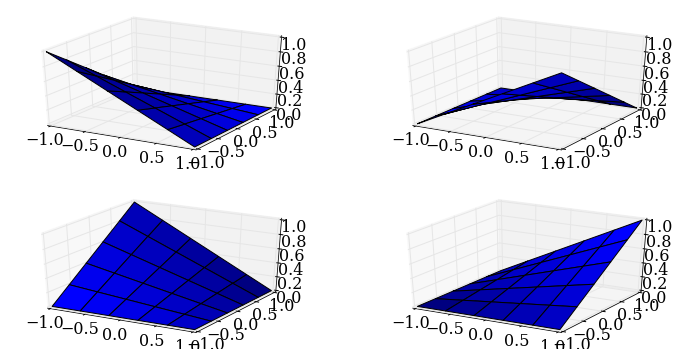

In [6]:
fig = pyplot.figure()
ax1 = fig.add_subplot(221,projection='3d')
ax1.plot_surface(Xi,Eta,N[0,:,:])
ax2 = fig.add_subplot(222,projection='3d')
ax2.plot_surface(Xi,Eta,N[1,:,:])
ax3 = fig.add_subplot(223,projection='3d')
ax3.plot_surface(Xi,Eta,N[2,:,:])
ax4 = fig.add_subplot(224,projection='3d')
ax4.plot_surface(Xi,Eta,N[3,:,:]);

Remember that for any function $f = f({\bf \xi})$ we can write $f = f^A N^A ({\bf \xi})$ where $f^A = f({\bf \xi}^A)$ is just a constant, the function evaluated at the node $A$.

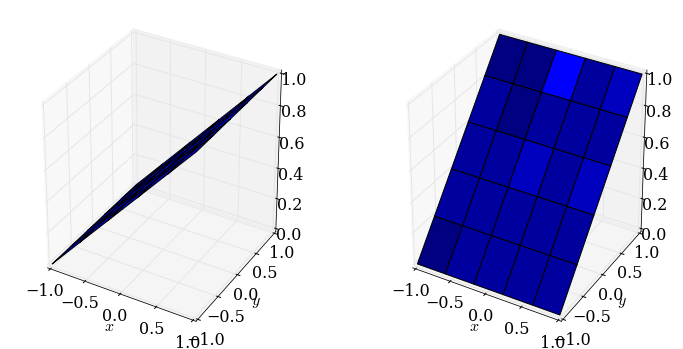

In [7]:
fig = pyplot.figure()
ax1 = fig.add_subplot(121,projection='3d')
ax1.plot_surface(Xi,Eta,N[1,:,:]+N[3,:,:]) # This should be x
ax1.set_xlabel(r"$x$");ax1.set_ylabel(r"$y$");
ax2 = fig.add_subplot(122,projection='3d')
ax2.plot_surface(Xi,Eta,N[2,:,:]+N[3,:,:]) # This should be y
ax2.set_xlabel(r"$x$");ax2.set_ylabel(r"$y$");

In [8]:
def deriv_shape_functions(coords):
    """
    Value of the derivatives of the shape functions wrt parametric coordinates at given parametric coordinates
    
    Parameters
    ----------
    
    coords : vector of float
        Parametric coordinates (xi, eta)
    
    Returns
    -------
    
    d_N_i : array of float
        The four shape functions at this point, derivatives wrt (xi, eta)
    """
    dN = numpy.zeros((2,4))
    dN[0,0] = -0.25*(1.0-coords[1])
    dN[0,1] = +0.25*(1.0-coords[1])
    dN[0,2] = -0.25*(1.0+coords[1])
    dN[0,3] = +0.25*(1.0+coords[1])
    dN[1,0] = -0.25*(1.0-coords[0])
    dN[1,1] = -0.25*(1.0+coords[0])
    dN[1,2] = +0.25*(1.0-coords[0])
    dN[1,3] = +0.25*(1.0+coords[0])
    
    return dN

In [9]:
def Jacobian(coords, node_coords):
    """
    Jacobian matrix at given parametric coordinates
    
    Parameters
    ----------
    
    coords : vector of float
        Parametric coordinates (xi, eta)
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    
    Returns
    -------
    
    J : array of float
        The Jacobian (d{x,y} / d{xi,eta})
    """
    
    dN = deriv_shape_functions(coords)
    J = numpy.dot(dN, node_coords)
    return J

In [10]:
def GaussQuad_Volume(field, node_coords):
    """
    Use two point Gauss quadrature to evaluate the integral of a field over an element
    
    Parameters
    ----------
    
    field : function
        A way of evaluating the field variable at given parametric coordinates within the element.
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    
    Returns
    -------
    
    I : float
        The integral over the element
    """
    
    point = 1.0/numpy.sqrt(3.0)
    I = 0
    I += numpy.linalg.det(Jacobian([-point,-point], node_coords))*field([-point,-point])
    I += numpy.linalg.det(Jacobian([point,-point], node_coords))*field([point,-point])
    I += numpy.linalg.det(Jacobian([-point,point], node_coords))*field([-point,point])
    I += numpy.linalg.det(Jacobian([point,point], node_coords))*field([point,point])
    
    return I

In [11]:
def GaussQuad_Boundary(field, node_coords, boundary):
    """
    Use two point Gauss quadrature to evaluate the integral of a field over one boundary of an element
    
    Parameters
    ----------
    
    field : function
        A way of evaluating the field variable at given parametric coordinates within the element.
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    boundary : int
        Which boundary to integrate over (0: bottom; 1: right, 2: top, 3: left)
    
    Returns
    -------
    
    I : float
        The integral over the element
    """
    
    point = 1.0/numpy.sqrt(3.0)
    if boundary == 0:
        loc1 = [-point, -1.0]
        loc2 = [point, -1.0]
    elif boundary == 1:
        loc1 = [1.0, -point]
        loc2 = [1.0, point]
    elif boundary == 2:
        loc1 = [-point, 1.0]
        loc2 = [point, 1.0]
    elif boundary == 3:
        loc1 = [1.0, -point]
        loc2 = [1.0, point]
    else:
        raise AssertionError("boundary value must be in 0-3")
        
    I = 0
    I += numpy.linalg.det(Jacobian(loc1, node_coords))*field(loc1)
    I += numpy.linalg.det(Jacobian(loc2, node_coords))*field(loc2)
    
    return I

In [12]:
def Bmatrix(coords, node_coords):
    """
    Strain-displacement B matrix (dN/dx = J^{-1} dN/dxi) at given parametric coordinates
    
    Parameters
    ----------
    
    coords : vector of float
        Parametric coordinates (xi, eta)
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    
    Returns
    -------
    
    B : array of float
        The Strain-displacement matrix 
    """
    
    dN = deriv_shape_functions(coords)
    J = Jacobian(coords, node_coords)
    B = numpy.dot(numpy.linalg.inv(J), dN)
    return B

In [13]:
domain = numpy.array([[0.0,1.0],[0.0,0.5]])
Nelements = [1,1]
nodes, IEN = mesh_generator(domain,Nelements)

In [14]:
def KD(i,j):
    """
    Kronecker delta
    """
    
    return int(i==j)

In [15]:
def generate_constituitive_relation(E, nu):
    """
    Return function giving the consituitive relation C_{ijkl}
    """
    
    lam = E * nu / (1.0 + nu) / (1.0 - 2.0 * nu)
    mu = E / 2.0 / (1.0 + nu)
    
    C = lambda i, j, k, l: lam*KD(i,j)*KD(k,l) + mu*(KD(i,k)*KD(j,l)+KD(i,l)*KD(j,k))

    return C

In [16]:
def stiffness_integrand(A, B, j, l, C, node_coords):
    """
    Return function giving the integrand for the stiffness matrix calculation
    """
    
    integrand = lambda coords : \
    C[0,j,0,l]*Bmatrix(coords, node_coords)[0,A]*Bmatrix(coords, node_coords)[0,B] + \
    C[1,j,0,l]*Bmatrix(coords, node_coords)[1,A]*Bmatrix(coords, node_coords)[0,B] + \
    C[0,j,1,l]*Bmatrix(coords, node_coords)[0,A]*Bmatrix(coords, node_coords)[1,B] + \
    C[1,j,1,l]*Bmatrix(coords, node_coords)[1,A]*Bmatrix(coords, node_coords)[1,B]
    
    return integrand

In [17]:
def element_stiffness(node_coords, C):
    """
    Compute the element stiffness matrix for a given element defined by its node locations
    """
    
    K = numpy.zeros((8,8))
    Ndims = 2
    Nnodes = 4
    for A in range(Nnodes):
        for j in range(Ndims):
            for B in range(Nnodes):
                for l in range(Ndims):
                    K[2*A+j, 2*B+l] = GaussQuad_Volume(stiffness_integrand(A,B,j,l,C,node_coords), node_coords)
    return K

In [18]:
def force_integrand(A, j):
    """
    A hand-hack for a single element here.
    """
    
    traction = [1.0e6, 0]
    
    integrand = lambda coords : traction[j]*shape_functions(coords)[A]
    
    return integrand

In [19]:
def load_boundary(node_coords):
    """
    Compute the force term due to the boundary.
    """
    
    F = numpy.zeros((8,1))
    Ndims = 2
    Nnodes = 4
    for A in range(Nnodes):
        for j in range(Ndims):
            F[2*A+j] = GaussQuad_Boundary(force_integrand(A,j), node_coords, boundary=1)
            
    return F

### Question 4

Using the Python programme from question 3, solve the following problem.

Consider a 2D rectangular solid domain (length $L_x = 1m$; height $L_y = 0.5m$) with material properties $\{ E = 210{\rm{ GPa}};\,\,\,\nu  = 0.3\} $ and sides labelled (counter-clockwise, starting from the left vertical side) as A, B, C and D.

The boundary conditions are as follows:


\begin{equation}
  u({\text{side}}\,{\text{A}}) = v({\text{side}}\,{\text{B}}) = 0
\end{equation}


The load condition is:


\begin{equation}
{\bf{F}}({\text{side C}})[Newton] = \left\{ \begin{array}{l}
{F_x}({\text{side C}})\\
{F_y}({\text{side C}})
\end{array} \right\} = \left\{ \begin{array}{l}
{10^6}\\
0
\end{array} \right\}
\end{equation}


**The boundary and loading conditions are homogeneous and therefore do not
introduce shear coupling. The Cauchy stress tensor has only one non-null
component, ${\sigma _{xx}}$.**

**NB:** the total load of 10$^{6}$ N must be uniformly distributed over all
the nodes of side C.

1. Solve the boundary-value problem of elasticity described above to calculate
the displacement of faces D and C. **You will consider 2 mesh sizes:** 1 for
which the whole structure is meshed *with one element only* and one size
of your choice.
2. Compare the solutions to the exact analytical solutions given by ${\sigma
_{xx}} = {F_x}/{L_y}$.

The strains can be calculated as 

$$
\begin{align}
{\varepsilon _{xx}} = {\sigma _{xx}}/E =
{F_x}/E{L_y} &=  - {\varepsilon _{yy}}/\nu \\  {\varepsilon _{xy}} &= 0
\end{align}
$$

and the displacements as 

$$
\begin{align}
  u &= {\varepsilon _{xx}}{L_x} \\ v &= {\varepsilon _{yy}}{L_y}.
\end{align}
$$

Do the results surprise you? Why?


#### Answer

Note $\sigma_{xx} = 2 \times 10^6$ giving $\varepsilon_{xx} = 9.52381 \times 10^{-4}$ and $\varepsilon_{yy} = -2.85714 \times 10^{-4}$ and hence $u = 9.52381 \times 10^{-4}$ and $v = -1.42857 \times 10^{-4}$.

In [20]:
# One element case
domain = numpy.array([[0.0,1.0],[0.0,0.5]])
Nelements = [1,1]
nodes, IEN = mesh_generator(domain,Nelements)

In [21]:
Ndims = 2
Nnodes = len(nodes)

In [22]:
C = numpy.zeros((Ndims,Ndims,Ndims,Ndims))
Cfn = generate_constituitive_relation(2.1e11, 0.3)
for i in range(Ndims):
    for j in range(Ndims):
        for k in range(Ndims):
            for l in range(Ndims):
                C[i,j,k,l] = Cfn(i,j,k,l)

In [23]:
K = element_stiffness(nodes, C)
F = load_boundary(nodes)
free_rows = numpy.array([2,5,6,7])
fixed_rows = numpy.array([0,1,3,4])
K_free = K[free_rows[:,numpy.newaxis], free_rows]
F_free = F[free_rows]
K_fixed = K[fixed_rows[:,numpy.newaxis], fixed_rows]
F_fixed = F[fixed_rows]
d_fixed = numpy.zeros((4,1))
d = numpy.linalg.solve(K_free, F_free-numpy.dot(K_fixed,d_fixed))
print(d)

[[  2.16666667e-06]
 [ -4.64285714e-07]
 [  2.16666667e-06]
 [ -4.64285714e-07]]


In [24]:
-d[1]/d[0] #Should be nu/2 = 0.15

array([ 0.21428571])